In [1]:
import os
import sys
import glob
import re
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
from IPython.display import display
from pathlib import Path
from smart_open import open
from tqdm.autonotebook import tqdm
tqdm.pandas()

import gensim
from gensim.utils import simple_preprocess
from gensim.models import Phrases
from gensim.models.phrases import Phraser

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.model_selection import cross_val_score, ShuffleSplit, train_test_split
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

import seaborn as sns

import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = stopwords.words('english')

%matplotlib inline

C:\Users\infomax\Anaconda3\lib\site-packages\tqdm\autonotebook\__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\infomax\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [64]:
import spacy
nlp = spacy.load('en_core_web_lg')

In [16]:
data = []
for cat in tqdm(os.listdir('bbc')):
    for fname in glob.glob('bbc/' + cat + '/*.txt'):
        file = Path(fname)
        iid = cat + '-' + file.name.split('.')[0]
        try:
            txt = file.read_text(encoding='latin-1')
        except:
            print(iid)
        data.append([iid, txt, cat])
        
df = pd.DataFrame(data, columns=['ArticleId', 'Text', 'Category']); df

,ArticleId,Text,Category
0,business-001,Ad sales boost Time Warner profit\n\nQuarterly...,business
1,business-002,Dollar gains on Greenspan speech\n\nThe dollar...,business
2,business-003,Yukos unit buyer faces loan claim\n\nThe owner...,business
3,business-004,High fuel prices hit BA's profits\n\nBritish A...,business
4,business-005,Pernod takeover talk lifts Domecq\n\nShares in...,business
5,business-006,Japan narrowly escapes recession\n\nJapan's ec...,business
6,business-007,Jobs growth still slow in the US\n\nThe US cre...,business
7,business-008,"India calls for fair trade rules\n\nIndia, whi...",business
8,business-009,Ethiopia's crop production up 24%\n\nEthiopia ...,business
9,business-010,Court rejects $280bn tobacco case\n\nA US gove...,business


In [4]:
df.Text[0]

'Ad sales boost Time Warner profit\n\nQuarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (Â£600m) for the three months to December, from $639m year-earlier.\n\nThe firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet connections and higher advert sales. TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn. Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL.\n\nTime Warner said on Friday that it now owns 8% of search-engine Google. But its own internet business, AOL, had has mixed fortunes. It lost 464,000 subscribers in the fourth quarter profits were lower than in the preceding three quarters. However, the company said AOL\'s underlying profit before exceptional items rose 8% on the back of stronger internet advertising revenues. It hopes to increase subscribers by offering the online service free to TimeWarner internet customers and will try to si

In [67]:
from spacy.pipeline import EntityRuler

ruler = EntityRuler(nlp)
patterns = [
#     {"label": "MONEY", "pattern": [{"TEXT": r"$"}, {"POS": "NUM"}]},
    {"label": "MONEY", "pattern": [{"TEXT": {"REGEX": r"[\$|€|¥|£]"}}, {"POS": "NUM"}]} #원화\ 는 잘 안된다...
]
ruler.add_patterns(patterns)
nlp.add_pipe(ruler, before='ner')

In [65]:
nlp.add_pipe(nlp.create_pipe('merge_entities'))
# nlp.add_pipe(nlp.create_pipe('merge_noun_chunks'))

In [69]:
for tok in nlp(df.Text[0]):
    print(tok)

Ad
sales
boost
Time Warner
profit



Quarterly
profits
at
US
media
giant
TimeWarner
jumped
76%
to
$1.13bn
(
Â£600
m
)
for
the three months to December
,
from
$639m
year-earlier
.



The
firm
,
which
is
now
one
of
the
biggest
investors
in
Google
,
benefited
from
sales
of
high
-
speed
internet
connections
and
higher
advert
sales
.
TimeWarner
said
fourth quarter
sales
rose
2%
to
$11.1bn
from
$10.9bn
.
Its
profits
were
buoyed
by
one
-
off
gains
which
offset
a
profit
dip
at
Warner Bros
,
and
less
users
for
AOL
.



Time
Warner
said
on
Friday
that
it
now
owns
8%
of
search
-
engine
Google
.
But
its
own
internet
business
,
AOL
,
had
has
mixed
fortunes
.
It
lost
464,000
subscribers
in
the fourth quarter
profits
were
lower
than
in
the preceding three quarters
.
However
,
the
company
said
AOL
's
underlying
profit
before
exceptional
items
rose
8%
on
the
back
of
stronger
internet
advertising
revenues
.
It
hopes
to
increase
subscribers
by
offering
the
online
service
free
to
TimeWarner
internet
custo

In [17]:
tmp.pos_

'PUNCT'

In [18]:
tmp.is_stop

False

In [11]:
tmp.lemma_

'high'

In [15]:
tmp.ent_type_

''

In [50]:
def sent_to_words(sentences):
    for sent in sentences:
        yield simple_preprocess(sent, deacc=True)
        
words = list(sent_to_words(df['Text']))

In [59]:
bigram_phrases = Phrases(words, min_count=5, threshold=100)
bigram_model = Phraser(bigram_phrases)

trigram_phrases = Phrases(bigram_model[words], threshold=100)
trigram_model = Phraser(trigram_phrases)

In [70]:
words_trigram = trigram_model[bigram_model[words]]

In [69]:
def lemmatize(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    # https://spacy.io/api/annotation
    
    texts_out = []
    for sent in texts:
        doc = nlp(' '.join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
        
    return texts_out

In [73]:
nlp = spa

['ad',
 'sales',
 'boost',
 'time',
 'warner',
 'profit',
 'quarterly',
 'profits',
 'at',
 'us',
 'media',
 'giant',
 'timewarner',
 'jumped',
 'to',
 'bn',
 'for',
 'the',
 'three',
 'months',
 'to',
 'december',
 'from',
 'year',
 'earlier',
 'the',
 'firm',
 'which',
 'is',
 'now',
 'one',
 'of',
 'the',
 'biggest',
 'investors',
 'in',
 'google',
 'benefited',
 'from',
 'sales',
 'of',
 'high_speed',
 'internet',
 'connections',
 'and',
 'higher',
 'advert',
 'sales',
 'timewarner',
 'said',
 'fourth_quarter',
 'sales',
 'rose',
 'to',
 'bn',
 'from',
 'bn',
 'its',
 'profits',
 'were',
 'buoyed',
 'by',
 'one',
 'off',
 'gains',
 'which',
 'offset',
 'profit',
 'dip',
 'at',
 'warner_bros',
 'and',
 'less',
 'users',
 'for',
 'aol',
 'time',
 'warner',
 'said',
 'on',
 'friday',
 'that',
 'it',
 'now',
 'owns',
 'of',
 'search_engine',
 'google',
 'but',
 'its',
 'own',
 'internet',
 'business',
 'aol',
 'had',
 'has',
 'mixed',
 'fortunes',
 'it',
 'lost',
 'subscribers',
 'in',

In [73]:
df['category_id'] = df['Category'].factorize()[0]
category_id_df = df[['Category', 'category_id']].drop_duplicates().sort_values('category_id'); category_id_df

,Category,category_id
0,business,0
510,entertainment,1
896,politics,2
1313,sport,3
1824,tech,4


In [74]:
category_to_id = dict(category_id_df.values); category_to_id

{'business': 0, 'entertainment': 1, 'politics': 2, 'sport': 3, 'tech': 4}

In [75]:
id_to_category = dict(category_id_df[['category_id', 'Category']].values); id_to_category

{0: 'business', 1: 'entertainment', 2: 'politics', 3: 'sport', 4: 'tech'}

In [76]:
df.sample(5, random_state=0)

,ArticleId,Text,Category,category_id
384,business-385,Tate & Lyle boss bags top award\n\nTate & Lyle...,business,0
1983,tech-160,Halo 2 sells five million copies\n\nMicrosoft ...,tech,4
985,politics-090,MSPs hear renewed climate warning\n\nClimate c...,politics,2
1386,sport-074,Pavey focuses on indoor success\n\nJo Pavey wi...,sport,3
1294,politics-399,Tories reject rethink on axed MP\n\nSacked MP ...,politics,2


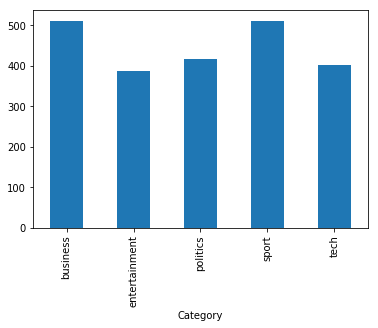

In [77]:
df.groupby('Category').category_id.count().plot.bar(ylim=0)

In [82]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1,2), stop_words='english')
features = tfidf.fit_transform(df.Text).toarray()
labels = df.category_id; features.shape

(2225, 14415)

In [105]:
N = 3

for Category, category_id in tqdm(sorted(category_to_id.items())):
    features_chi2 = chi2(features, labels==category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' '))==1]
    bigrams = [v for v in feature_names if len(v.split(' '))==2]
    print('# {}'.format(Category))
    print('  .Most correlated unigrams:\n    .{}'.format('\n    .'.join(unigrams[-N:])))
    print('  .Most correlated bigrams:\n    .{}'.format('\n    .'.join(bigrams[-N:])))

# business
  .Most correlated unigrams:
    .oil
    .growth
    .shares
  .Most correlated bigrams:
    .analysts said
    .economic growth
    .stock market
# entertainment
  .Most correlated unigrams:
    .singer
    .actor
    .film
  .Most correlated bigrams:
    .los angeles
    .film festival
    .box office
# politics
  .Most correlated unigrams:
    .blair
    .election
    .labour
  .Most correlated bigrams:
    .prime minister
    .tony blair
    .mr blair
# sport
  .Most correlated unigrams:
    .coach
    .match
    .cup
  .Most correlated bigrams:
    .grand slam
    .australian open
    .champions league
# tech
  .Most correlated unigrams:
    .technology
    .software
    .users
  .Most correlated bigrams:
    .anti virus
    .mobile phones
    .mobile phone



In [110]:
SAMPLE_SIZE = int(len(features)*0.3)
np.random.seed(0)
indices = np.random.choice(range(len(features)), size=SAMPLE_SIZE, replace=False)
projected_features = TSNE(n_components=2, random_state=0).fit_transform(features[indices]); projected_features.shape

(667, 2)

In [115]:
category_id_test = 0
projected_features[labels[indices]==category_id_test]

array([[ 20.867317 , -24.286161 ],
       [ 32.15504  , -34.496788 ],
       [ 21.945278 , -28.672266 ],
       [ 10.729226 , -22.20582  ],
       [-15.323385 , -11.129261 ],
       [ 13.543248 , -35.330227 ],
       [ 13.5722475, -16.537634 ],
       [ 30.31591  , -27.98926  ],
       [ 38.132023 , -23.728315 ],
       [ 10.157736 , -33.80925  ],
       [ 26.371328 , -37.92122  ],
       [ 15.23539  , -34.75432  ],
       [ 15.68058  , -32.66936  ],
       [ 16.843668 , -22.685152 ],
       [ 17.596556 , -28.77592  ],
       [  7.954508 ,  -9.466415 ],
       [ 25.484049 , -18.129175 ],
       [  9.885706 , -13.634229 ],
       [  6.8335476, -12.146235 ],
       [ -1.2814156,  -6.5572157],
       [  4.393556 , -18.388744 ],
       [ 24.894709 , -37.420197 ],
       [ 26.115585 , -38.80898  ],
       [ 25.866795 , -41.043808 ],
       [ 12.362574 , -22.257097 ],
       [ 26.460035 , -41.3697   ],
       [ 21.773987 , -20.330444 ],
       [ 11.0408125,  -9.513612 ],
       [ 24.104187 ,

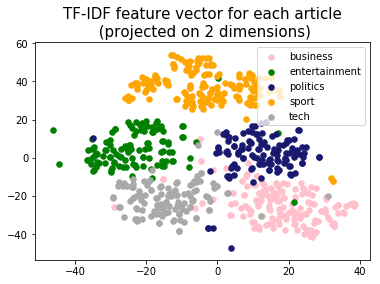

In [130]:
colors = ['pink', 'green', 'midnightblue', 'orange', 'darkgrey']

for category, category_id in sorted(category_to_id.items()):
    points = projected_features[labels[indices]==category_id]
    plt.scatter(points[:,0], points[:,1], s=30, c=colors[category_id], label=category)
    
plt.title('TF-IDF feature vector for each article\n (projected on 2 dimensions)', fontdict=dict(fontsize=15))
plt.legend();

In [136]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0), 
    MultinomialNB(), 
    LogisticRegression(random_state=0, solver='lbfgs', multi_class='auto')
]

In [153]:
# CV = 5
shufflesplit = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
entries = []

for model in tqdm(models):
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=shufflesplit)
    
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))

In [151]:
cv_df = pd.DataFrame(entries, index=range(CV*len(models)), columns=['model_name', 'fold_idx', 'accuracy']); cv_df

,model_name,fold_idx,accuracy
0,RandomForestClassifier,0,0.851685
1,RandomForestClassifier,1,0.820225
2,RandomForestClassifier,2,0.811236
3,RandomForestClassifier,3,0.784270
4,RandomForestClassifier,4,0.782022
5,MultinomialNB,0,0.966292
6,MultinomialNB,1,0.970787
7,MultinomialNB,2,0.968539
8,MultinomialNB,3,0.966292
9,MultinomialNB,4,0.982022


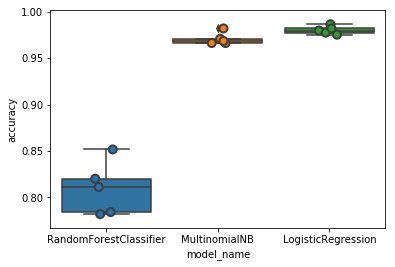

In [155]:
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, size=8, jitter=True, edgecolor='gray', linewidth=2)

In [180]:
model = LogisticRegression(random_state=0, solver='lbfgs', multi_class='auto')
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)

y_pred_proba = model.predict_proba(X_test)
y_pred = model.predict(X_test)

In [182]:
conf_mat = confusion_matrix(y_test, y_pred); conf_mat

array([[168,   0,   2,   0,   3],
       [  0, 122,   1,   0,   0],
       [  3,   0, 137,   0,   0],
       [  1,   0,   0, 172,   0],
       [  6,   0,   0,   0, 120]], dtype=int64)

Text(0.5, 15.0, 'Predicted')

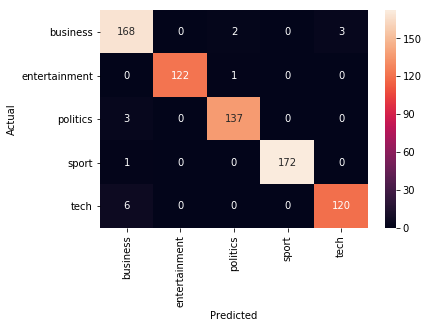

In [184]:
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=category_id_df.Category.values, yticklabels=category_id_df.Category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [196]:
for predicted in category_id_df.category_id:
    for actual in category_id_df.category_id:
        if predicted != actual and conf_mat[actual, predicted] >= 2:
            print('{} predicted as {}: {} examples'.format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
            display(df.loc[indices_test[(y_test==actual) & (y_pred==predicted)]]['Text'])

politics predicted as business: 3 examples


933    Borders rail link campaign rally\n\nCampaigner...
971    Report attacks defence spending\n\nThe Ministr...
979    Job cuts 'false economy'  - TUC\n\nPlans to sh...
Name: Text, dtype: object

tech predicted as business: 6 examples


1955    US duo in first spam conviction\n\nA brother a...
2065    PC ownership to 'double by 2010'\n\nThe number...
1942    Argonaut founder rebuilds empire\n\nJez San, t...
1999    US duo in first spam conviction\n\nA brother a...
2213    Anti-spam laws bite spammer hard\n\nThe net's ...
1937    Games maker fights for survival\n\nOne of Brit...
Name: Text, dtype: object

business predicted as politics: 2 examples


132    Salary scandal in Cameroon\n\nCameroon says wi...
486    World leaders gather to face uncertainty\n\nMo...
Name: Text, dtype: object

business predicted as tech: 3 examples


446    News Corp eyes video games market\n\nNews Corp...
253    News Corp eyes video games market\n\nNews Corp...
204    Orange colour clash set for court\n\nA row ove...
Name: Text, dtype: object

In [197]:
model.fit(features, labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='auto',
          n_jobs=None, penalty='l2', random_state=0, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [200]:
N = 3

for Category, category_id in tqdm(sorted(category_to_id.items())):
    indices = np.argsort(model.coef_[category_id])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' '))==1]
    bigrams = [v for v in feature_names if len(v.split(' '))==2]
    print('# {}'.format(Category))
    print('  .Most correlated unigrams:\n    .{}'.format('\n    .'.join(unigrams[-N:])))
    print('  .Most correlated bigrams:\n    .{}'.format('\n    .'.join(bigrams[-N:])))

# business
  .Most correlated unigrams:
    .bank
    .shares
    .company
  .Most correlated bigrams:
    .analysts said
    .stock market
    .chief executive
# entertainment
  .Most correlated unigrams:
    .singer
    .music
    .film
  .Most correlated bigrams:
    .new york
    .los angeles
    .box office
# politics
  .Most correlated unigrams:
    .mr
    .party
    .labour
  .Most correlated bigrams:
    .prime minister
    .tony blair
    .mr blair
# sport
  .Most correlated unigrams:
    .club
    .cup
    .match
  .Most correlated bigrams:
    .champions league
    .australian open
    .year old
# tech
  .Most correlated unigrams:
    .technology
    .users
    .computer
  .Most correlated bigrams:
    .bbc news
    .news website
    .said mr



In [219]:
fnames_test = glob.glob('newsdata/downloaded/*.json')[:20]

test_data = []
for fname in fnames_test:
    with open(fname, encoding='UTF-8-sig') as f:
        content = json.load(f)
        test_data.append(content['text'])

In [220]:
fnames_test

['newsdata/downloaded\\000652e2220a7894aa0c1712015a4a5f1d32e812.json',
 'newsdata/downloaded\\0006580b18f39ccc8e033eddb28f529ec734fc97.json',
 'newsdata/downloaded\\000945f1dfd1ce655581ad58aa3118e80efd3256.json',
 'newsdata/downloaded\\0009e30b67cedd0accfbed44b81ca6dbf6c6abc6.json',
 'newsdata/downloaded\\000b1161c238cf737a8122a618d580ac9497a96f.json',
 'newsdata/downloaded\\00120c5c51226b89d319e107eb88d9a40c105fc3.json',
 'newsdata/downloaded\\00138e4f32f8edc9be06cdcbbaf5a5257c76ca59.json',
 'newsdata/downloaded\\001504bdb32d757d1554a760477b38e095f8ae35.json',
 'newsdata/downloaded\\001650688dcde68b56cda331f62a2bd65c48465b.json',
 'newsdata/downloaded\\001b13950a1b8b99c8bf4041c252106bcfa00186.json',
 'newsdata/downloaded\\001c2005d33556a5425a4fa8e0f15011a0a66dc9.json',
 'newsdata/downloaded\\0020451f86319f32e40ec6a017afa1edaf41e668.json',
 'newsdata/downloaded\\00262225974b77fdb7392e76d1aa4c4aac657e64.json',
 'newsdata/downloaded\\002b54987888f06aab07900c148e1c1fc2f82f92.json',
 'news

In [221]:
test_features = tfidf.transform(test_data)

In [222]:
Y_pred = model.predict(test_features); Y_pred

array([1, 0, 1, 0, 1, 0, 1, 1, 2, 0, 4, 2, 1, 4, 1, 0, 1, 0, 3, 2],
      dtype=int64)

In [223]:
[id_to_category[cat_id] for cat_id in Y_pred]

['entertainment',
 'business',
 'entertainment',
 'business',
 'entertainment',
 'business',
 'entertainment',
 'entertainment',
 'politics',
 'business',
 'tech',
 'politics',
 'entertainment',
 'tech',
 'entertainment',
 'business',
 'entertainment',
 'business',
 'sport',
 'politics']

In [12]:
with open('newsdata/downloaded/002b54987888f06aab07900c148e1c1fc2f82f92.json') as f:
    content = json.load(f)
    print(content['text'])
    print(simple_preprocess(content['text'], deacc=True))

In my mind's eye, I see University Avenue in Palo Alto littered with Philz coffee cups, rogue boba pearls, and strewn hover boards. A Stanford undergraduate computer science student weeps into their MacBook as their code loops endlessly. Batman-style doors lift up; a tech exec tumbles out of his Model X car and crawls frantically to the nearest electric charging port. Two VC-bros poke their chopsticks at toro at the Palo Alto Nobu and discuss seed funding the Uber-of-vegan-soft-serve that Elon Musk will, most definitely, franchise on Mars. Mark Zuckerberg peers out from a manhole on the street while Jack Dorsey directs traffic around him and recites his tweets from 2006.

I lived in Palo Alto for a handful of years, and San Francisco for a stint. My memories now converge as a tableau of farce, like the above.

In such a historically fertile incubator — where you can succeed beyond known measure or fail spectacularly — the air is fraught. But actually being stressed is taboo, so techies